In [1]:
import torch

from torch import nn, optim
from jcopdl.callback import Callback, set_config

#cek apakah gpu bisa digunakan
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# **Data Set Dan Loader**

In [2]:
#berguna khusus data set gambar
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [3]:
#karna data gambar kita perlu transform terlebih dahulu
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor()
])

train_set = datasets.ImageFolder("data/train/", transform=transform)
trainloader = DataLoader(train_set, batch_size = 128, shuffle = True)

test_set = datasets.ImageFolder("data/test/", transform=transform)
testloader = DataLoader(test_set, batch_size = 128, shuffle = True)

In [24]:
images, labels = next(iter(trainloader))

In [25]:
images.shape

torch.Size([128, 1, 28, 28])

In [27]:
labelcat= train_set.classes
labelcat

['Ankle boot',
 'Bag',
 'Coat',
 'Dress',
 'Pullover',
 'Sandal',
 'Shirt',
 'Sneaker',
 'T-shirt or Top',
 'Trouser']

# **Arsitektur Config**

In [7]:
from jcopdl.layers import linear_block

In [8]:
class ArsitekturSendiri(nn.Module):
    def __init__(self, input_size, n1, n2, output_size, dropout=0.2):
        super().__init__()
        #buat variabel fullconected ann karna semua layer terhubung
        self.fc = nn.Sequential(
            nn.Flatten(),
            linear_block(input_size, n1, dropout=dropout),
            linear_block(n1, n2, dropout=dropout),
            linear_block(n2, output_size, activation="lsoftmax")
        )
        
    def forward(self, x):
        return self.fc(x)

- model/layer yang berakhir linear gunanakan nn.MSEloss
- model/layer yang berakhir logsoftmax gunanakan nn.NLLloss
- model/layer yang berakhir sigmoid gunanakan nn.BCEloss
**pada kali ini model diakhiri lsogmax jadi nanti pada criterion kita gunakan ``NLLloss``**

# **Persiapan Traning**

In [9]:
config = set_config({
    "input_size": 784, 
    "n1": 256, 
    "n2": 64, 
    "output_size": len(train_set.classes),
    "dropout": 0.2
})

In [10]:
#konsep MCOC
model = ArsitekturSendiri(config.input_size, config.n1, config.n2, config.output_size, config.dropout).to(device)
criterion = nn.NLLLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, outdir="model")

# **Training**

In [11]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    
    cost = correct = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output = model(feature) #fedforward
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward() #backprop
            optimizer.step() #update weight
            optimizer.zero_grad()
        
        cost += loss.item() * feature.shape[0]
        correct += (output.argmax(1) == target).sum().item()
        
    cost = cost / len(dataset)
    acc =  correct / len(dataset)
    return cost, acc

Train:   0%|          | 0/313 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch     1
Train_cost  = 0.7313 | Test_cost  = 0.4660 | Train_score = 0.7397 | Test_score = 0.8320 |


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch     2
Train_cost  = 0.4735 | Test_cost  = 0.3969 | Train_score = 0.8335 | Test_score = 0.8558 |


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch     3
Train_cost  = 0.4213 | Test_cost  = 0.3816 | Train_score = 0.8497 | Test_score = 0.8581 |


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch     4
Train_cost  = 0.3934 | Test_cost  = 0.3528 | Train_score = 0.8589 | Test_score = 0.8710 |


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch     5
Train_cost  = 0.3702 | Test_cost  = 0.3533 | Train_score = 0.8670 | Test_score = 0.8688 |
==> EarlyStop patience =  1 | Best test_score: 0.8710


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch     6
Train_cost  = 0.3538 | Test_cost  = 0.3448 | Train_score = 0.8735 | Test_score = 0.8750 |


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch     7
Train_cost  = 0.3435 | Test_cost  = 0.3312 | Train_score = 0.8763 | Test_score = 0.8785 |


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch     8
Train_cost  = 0.3286 | Test_cost  = 0.3271 | Train_score = 0.8812 | Test_score = 0.8800 |


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch     9
Train_cost  = 0.3193 | Test_cost  = 0.3230 | Train_score = 0.8853 | Test_score = 0.8810 |


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch    10
Train_cost  = 0.3068 | Test_cost  = 0.3205 | Train_score = 0.8900 | Test_score = 0.8798 |
==> EarlyStop patience =  1 | Best test_score: 0.8810


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch    11
Train_cost  = 0.2998 | Test_cost  = 0.3107 | Train_score = 0.8914 | Test_score = 0.8857 |


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch    12
Train_cost  = 0.2925 | Test_cost  = 0.3107 | Train_score = 0.8916 | Test_score = 0.8855 |
==> EarlyStop patience =  1 | Best test_score: 0.8857


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch    13
Train_cost  = 0.2861 | Test_cost  = 0.3279 | Train_score = 0.8959 | Test_score = 0.8807 |
==> EarlyStop patience =  2 | Best test_score: 0.8857


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch    14
Train_cost  = 0.2828 | Test_cost  = 0.3122 | Train_score = 0.8958 | Test_score = 0.8867 |


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch    15
Train_cost  = 0.2731 | Test_cost  = 0.3109 | Train_score = 0.9000 | Test_score = 0.8854 |
==> EarlyStop patience =  1 | Best test_score: 0.8867


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch    16
Train_cost  = 0.2685 | Test_cost  = 0.3165 | Train_score = 0.9019 | Test_score = 0.8841 |
==> EarlyStop patience =  2 | Best test_score: 0.8867


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch    17
Train_cost  = 0.2629 | Test_cost  = 0.3171 | Train_score = 0.9037 | Test_score = 0.8847 |
==> EarlyStop patience =  3 | Best test_score: 0.8867


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch    18
Train_cost  = 0.2595 | Test_cost  = 0.3086 | Train_score = 0.9028 | Test_score = 0.8864 |
==> EarlyStop patience =  4 | Best test_score: 0.8867


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch    19
Train_cost  = 0.2507 | Test_cost  = 0.3228 | Train_score = 0.9070 | Test_score = 0.8857 |
==> EarlyStop patience =  5 | Best test_score: 0.8867
==> Execute Early Stopping at epoch: 19 | Best test_score: 0.8867
==> Best model is saved at model


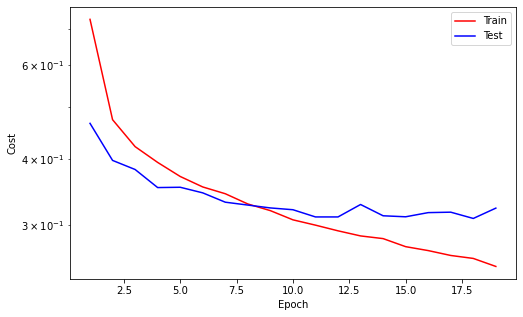

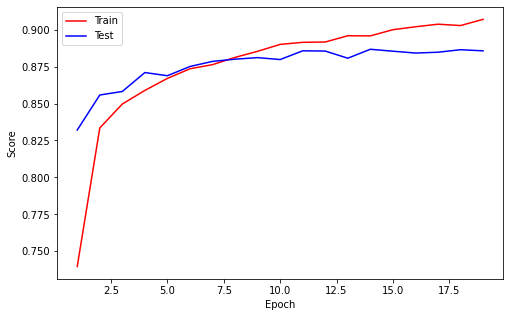

In [12]:
while True:
    train_cost, train_score = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost, test_score = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
    
    #Logging
    callback.log(train_cost, test_cost, train_score, test_score)
    
    #Checkpoint
    callback.save_checkpoint()
    
    #Runtime Plotting
    callback.cost_runtime_plotting()
    callback.score_runtime_plotting()
    
    #Early Stopping
    if callback.early_stopping(model, monitor="test_score"):
        callback.plot_cost()
        callback.plot_score()
        break

# **Load Best Model**

In [13]:
#sebenarnya ketika dia stop dia otomatis load model yang terbaik, akan tetapi jika ingin manual code seperti berikut

weights = torch.load("model/weights_best.pth",map_location="cpu")
config = torch.load("model/configs.pth",map_location="cpu")
model = ArsitekturSendiri(config.input_size, config.n1, config.n2, config.output_size, config.dropout).to(device)

model.load_state_dict(weights)
model = model.to(device)

# **Predict**

In [19]:
# untuk predict pake data loader
feature, target = next(iter(testloader))
feature, target = feature.to(device), target.to(device)

In [20]:
with torch.no_grad():
    model.eval()
    output = model(feature)#forward
    #argmax ambil probability yang paling tinggi
    preds = output.argmax(1)
preds

tensor([4, 0, 2, 6, 1, 4, 7, 3, 4, 5, 8, 6, 8, 7, 0, 2, 5, 7, 3, 7, 8, 1, 1, 7,
        3, 8, 7, 0, 7, 7, 8, 7, 2, 6, 8, 2, 2, 6, 2, 0, 4, 0, 8, 9, 4, 6, 5, 8,
        9, 6, 0, 9, 7, 6, 2, 7, 5, 5, 1, 2, 4, 7, 7, 4, 6, 6, 5, 9, 9, 0, 2, 1,
        8, 7, 7, 6, 0, 1, 9, 0, 9, 2, 6, 5, 1, 2, 5, 9, 0, 8, 2, 9, 2, 1, 0, 6,
        5, 2, 5, 5, 9, 9, 6, 2, 2, 6, 1, 2, 1, 8, 5, 8, 3, 3, 1, 6, 0, 7, 6, 7,
        0, 7, 2, 1, 4, 1, 1, 0])

# **Plotting**

In [22]:
import matplotlib.pyplot as plt

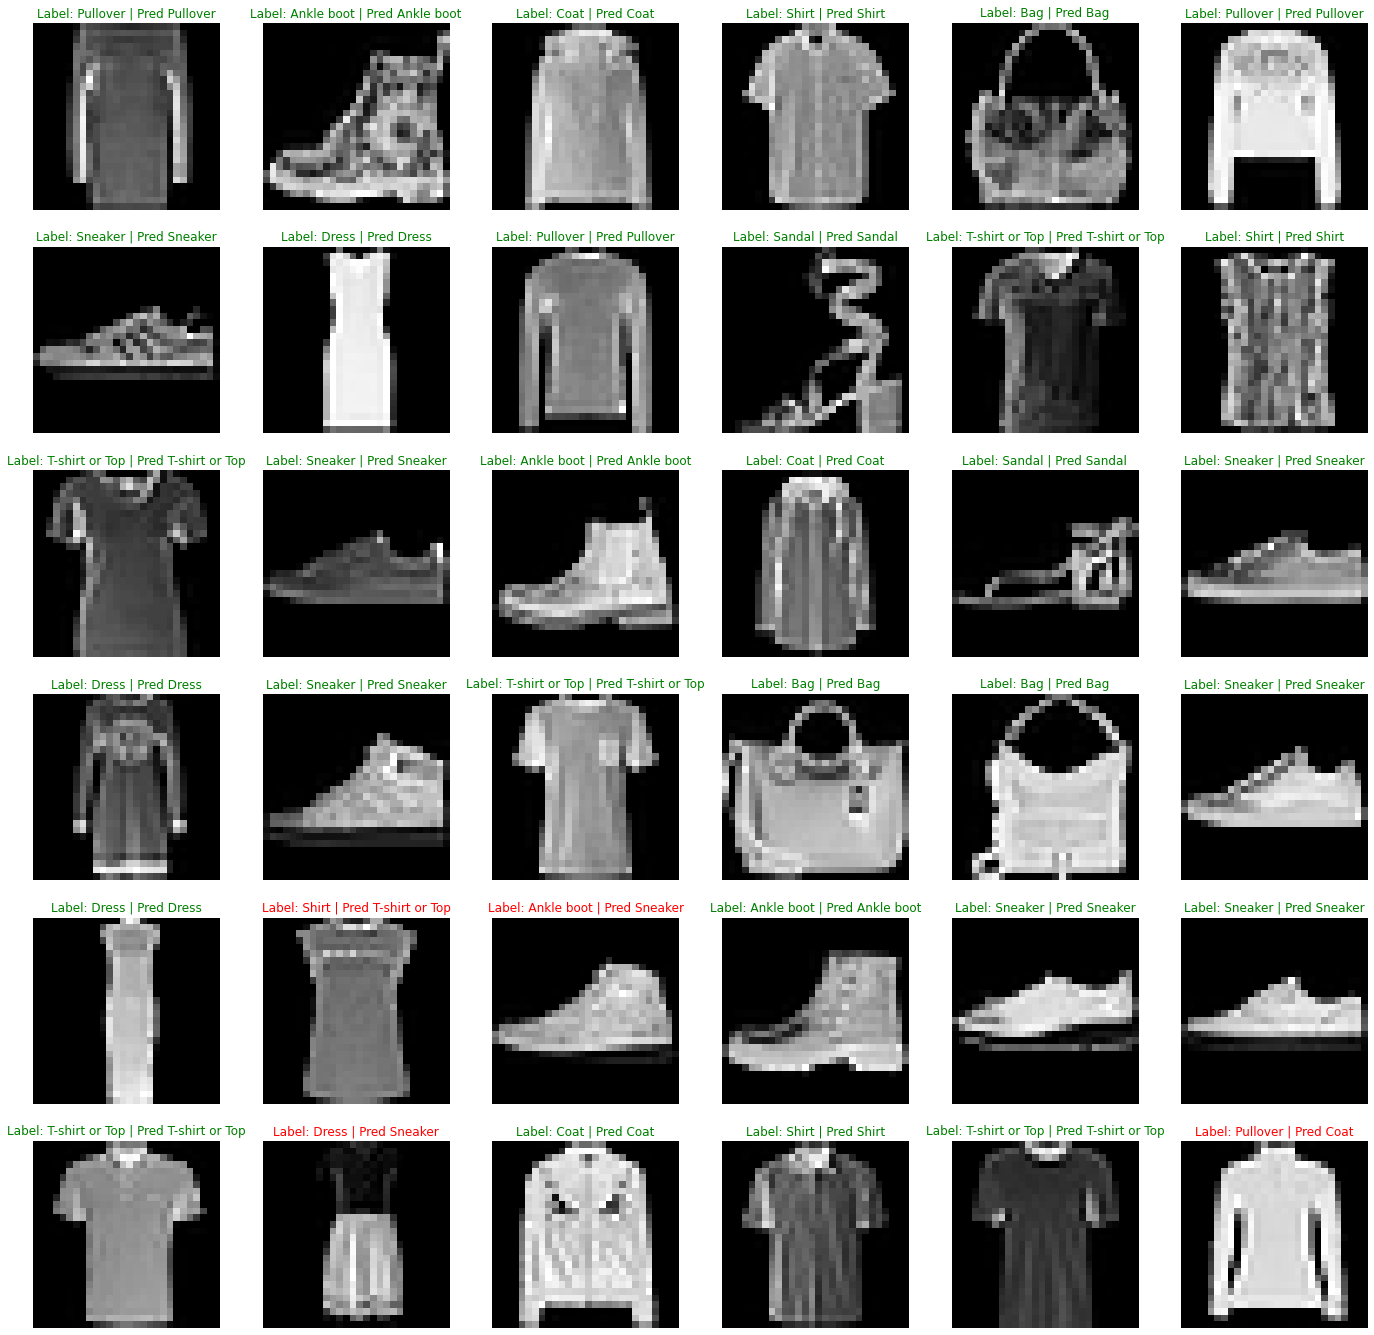

In [39]:
fig, axes = plt.subplots(6, 6, figsize=(24,24))
for img, label, pred, ax in zip(feature, target, preds, axes.flatten()):
    ax.imshow(img.view(28,28).cpu(), cmap="gray")
    font = {"color":"r"} if label != pred else {"color":"g"}
    label, pred = labelcat[label.item()], labelcat[pred.item()]
    ax.set_title(f"Label: {label} | Pred {pred}", fontdict = font)
    ax.axis("off")